In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from math import floor
import csv
from read_roi import read_roi_file, read_roi_zip
from glob import glob
import pickle

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        
        binsize = self.windowsize
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        gauss_array = np.zeros((n,totalsize))
        l = int(totalsize/binsize) # number of resulting layers
        
        if gaussian:
            for i in range(n):
                gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
        else: gauss_array = array
            
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
            
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))

    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
                    
        sp = np.nonzero(binned_binary_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       figure = fig, 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 10)
        ax.tick_params(axis = 'y', labelsize = 13)
    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = cmap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()
    
    def update_interlayer(self, spikes, X, omega_global, percentage, method):
        
        binned_spikes = self.bin_time_series(spikes, gaussian = False)
        sp = np.nonzero(binned_spikes)
        
        layers ,num_neurons, t = self.length, self.N, self.windowsize
        
        count_spikes = np.zeros((layers, num_neurons))
        interlayer = np.ones((layers-1, num_neurons))
    
        if method == 'local':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            for i in range(layers-1):
                zscores = zscore(np.diff(count_spikes, axis = 0)[i])
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage * omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)

        elif method == 'global':
            for i in range(len(sp[0])):
                l, n, t = sp[0][i], sp[1][i], sp[2][i]
                count_spikes[l][n] = count_spikes[l][n] + 1
            interlayers = []
            zscores = zscore(sum(np.diff(count_spikes, axis = 0)))
            for i in range(layers-1):
                layerweights = []
                for j in range(num_neurons):
                    if zscores[j] <= X: layerweights.append(percentage * omega_global)
                    else: layerweights.append(omega_global)
                interlayers.append(layerweights)
    
        #TODO:::  elif method == 'adjacent':
    
        return(interlayers)

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def read_csv(path, output, subject, roi):
    spike = open( path + output + subject + "_spikes_complexity.csv", "r")
    reader_spike = csv.reader(spike)
    n = read_roi(path, roi, subject)
    spikes = np.zeros((n,8000)) # roi x time

    for i,line in enumerate(reader_spike):
        for j in range(len(line)):
            spikes[i][j]=line[j]
            
    return(spikes)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def read_pv(path, m_type, mice):# this only read pv cells so far, TODO extend this to sst and non-track mice
    
    ##m_type: either 'het' or 'wt'
    
    het_or_wt = 'pv_' + m_type
    pvs = load_obj(path, het_or_wt)
    subject = mice.split('_')[0] + '_' + mice.split('_')[1] + '_' + mice.split('_')[2] + '_' + mice.split('_')[3]
    
    if mice.split('_')[-1] == 'baseline':index = 0
    elif mice.split('_')[-1] == 'early':index = 1
    elif mice.split('_')[-1] == 'pre':index = 2
        
    pv_indices=[i for i in pvs[subject][index]]#adjust python indexing starting from 0
    
    return(pv_indices)
            
def read_roi(path, roi, subject_roi):
    roi = read_roi_zip(glob(path+roi+subject_roi +'.zip')[0])
    n = len(roi)
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t), dtype = bool)
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = True
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def spike_count(spikes, ax, num_bins = None, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    binary = binarize(spikes)
    for i in range(n):
        spike_count.append(np.sum(binary[i][t_min:t_max]))
    if num_bins is None: num_bins = np.max(spike_count) - np.min(spike_count)
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution")
    ax.set_xlabel("Total Number of Spikes", fontsize = 22)
    ax.set_ylabel("Number of Neurons", fontsize = 22)
    return(n,bins)

def remove_non_firing(spikes, thresh, pv):
    n,t = spikes.shape
    indices = []
    for i in range(n):
        if len(np.nonzero(spikes[i])[0]) >= thresh:
            indices.append(i)
    removed_spikes = np.zeros((len(indices),t))
    for i,e in enumerate(indices):
        removed_spikes[i] = spikes[e]
    removed_neurons = list(set([i for i in range(n)])-set(indices))
    
    ##update pv indices
    new_pvs = np.array(sorted(pv))
    for i,e in enumerate(sorted(removed_neurons)):
        new_pvs = np.append(new_pvs[new_pvs<e],new_pvs[new_pvs>e]-1, axis = 0)
    list(new_pvs)
    
    return(removed_spikes, removed_neurons, new_pvs)

In [5]:
path = '/Users/bengieru/MLN/data/' ## base path
output = 'Johan_Clean_Traces_Features_and_Spikes/' #spikes and traces file
roi = 'sarah_ROI/' #roi file
subject = 'm_1_session_1_baseline'# subject

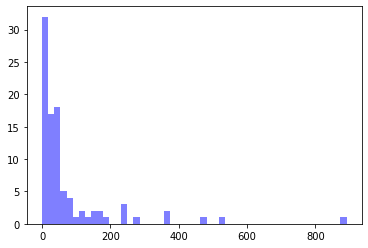

(array([32., 17., 18.,  5.,  4.,  1.,  2.,  1.,  2.,  2.,  1.,  0.,  0.,
         3.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  0.        ,  17.8289816 ,  35.6579632 ,  53.4869448 ,
         71.3159264 ,  89.144908  , 106.9738896 , 124.8028712 ,
        142.63185279, 160.46083439, 178.28981599, 196.11879759,
        213.94777919, 231.77676079, 249.60574239, 267.43472399,
        285.26370559, 303.09268719, 320.92166879, 338.75065039,
        356.57963199, 374.40861359, 392.23759519, 410.06657678,
        427.89555838, 445.72453998, 463.55352158, 481.38250318,
        499.21148478, 517.04046638, 534.86944798, 552.69842958,
        570.52741118, 588.35639278, 606.18537438, 624.01435598,
        641.84333758, 659.67231918, 677.50130077, 695.33028237,
        713.15926397, 730.98824557, 748.81722717, 766.64620877,
        784.

In [6]:
time = 500 ## binning the time into chunks of
n = read_roi(path, roi, subject) ## number of rois
layers = int(8000/time) ## number of layers
traces, spikes = read_csv(path, output, subject, roi) #read the networks
binned_spikes = bin_time_series(spikes, time, gaussian = True, sigma = 0.25) # bin the spikes into fixed length and apply gaussian kernel of length 3

binary_spikes = binarize(spikes) #binarize the spikes, i.e. ignore spike complexity
binned_binary_spikes = bin_time_series(binary_spikes, time, gaussian = False)#since we use this for raster plot, no need to take the gaussian

spike_count(spikes, 50)

In [7]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


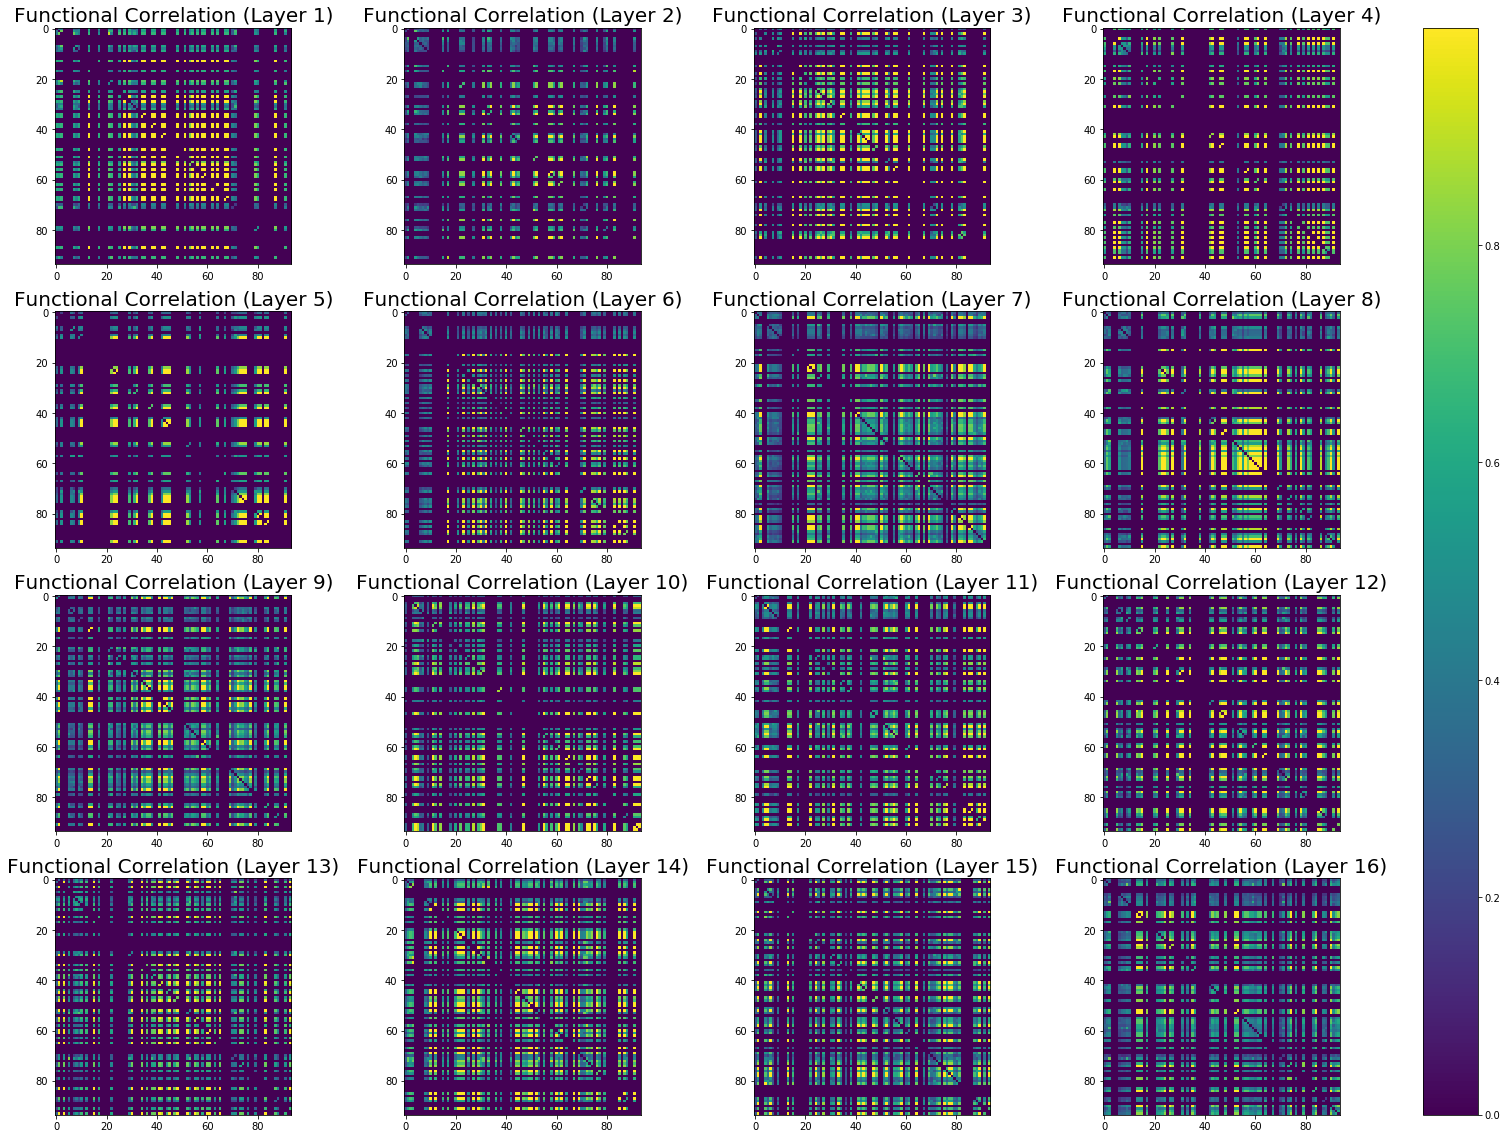

In [8]:
fig,ax = plt.subplots(4,4,figsize=(30,20))
for i in range(4):
    for j in range(4):
        im = ax[i][j].imshow(adjacency_matrices[i*4+j])
        ax[i][j].set_title('Functional Correlation (Layer %d)'%(i*4+j+1), fontsize = 20)
        
fig.colorbar(im, ax = ax.ravel().tolist())

#plt.savefig('/user/bengieru/adjacency_matrices.pdf')

#plt.tight_layout()

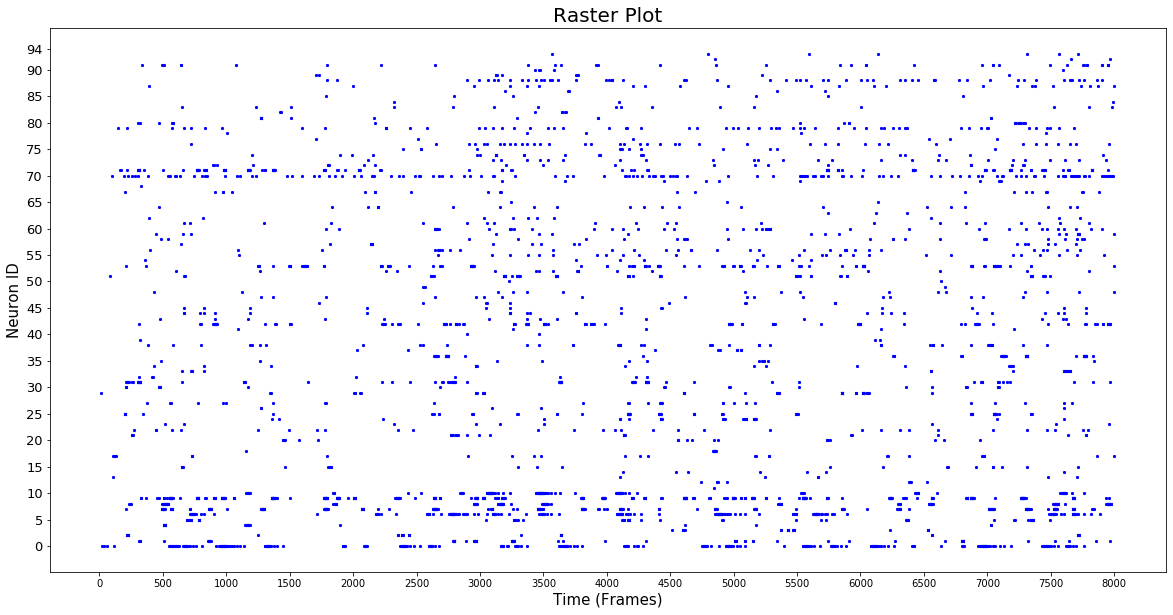

In [9]:
TN = temporal_network(n, layers, time, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')
pv = read_pv(path+'subjects/','het',subject)

fig,ax = plt.subplots(1,1, figsize = (20,10))
TN.raster_plot(spikes, ax)

In [10]:
A = np.array([[0,1,0,1],[1,0,0,1],[0,0,0,1],[1,1,1,0]])
B = np.array([[0,0,1,0],[0,0,1,1],[1,1,0,0],[0,1,0,0]])
adjacency = [A,B]
TN_test = temporal_network(4, 2, 4, data = 'list__adjacency', list_adjacency = adjacency, omega = 1, kind = 'ordinal')
#TN_test.edgelist

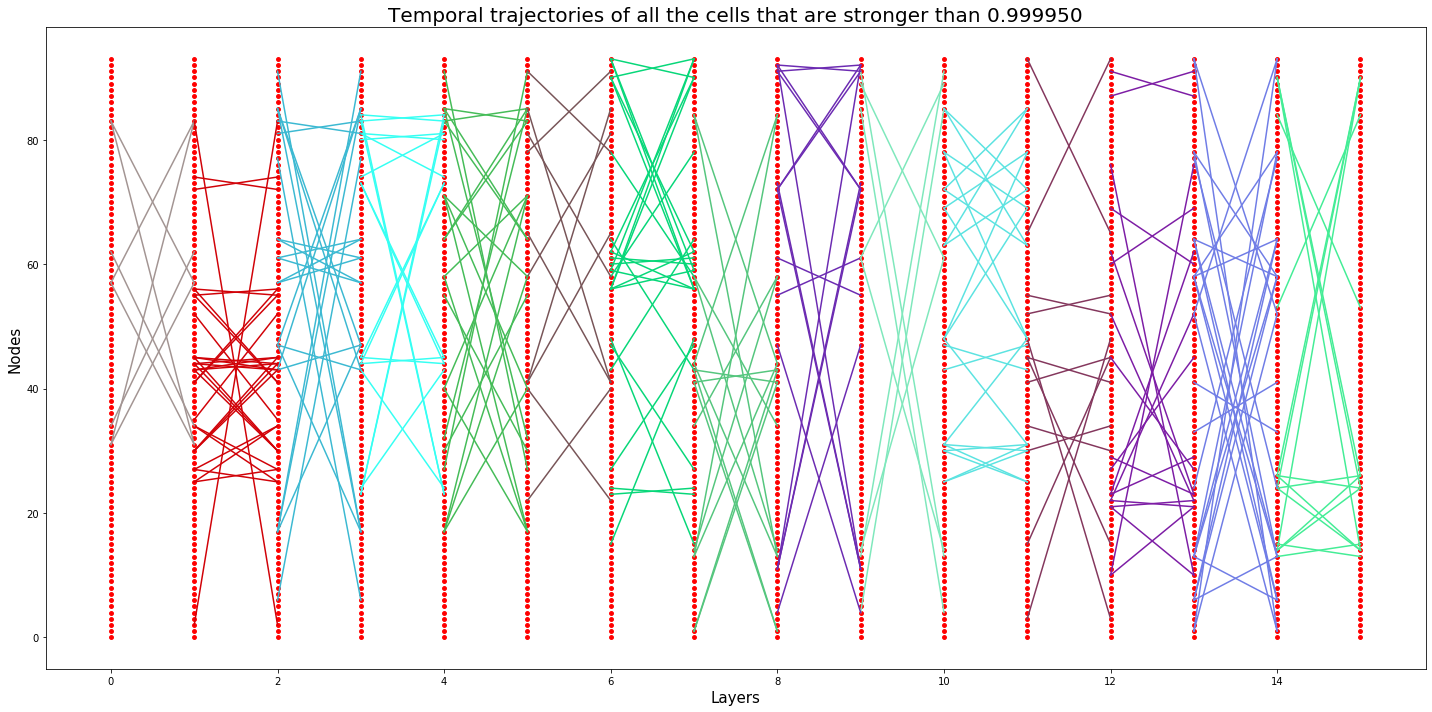

In [11]:
TN.trajectories(thresh = 0.99995, node_id = None, community = None, edge_color = True, pv = None)

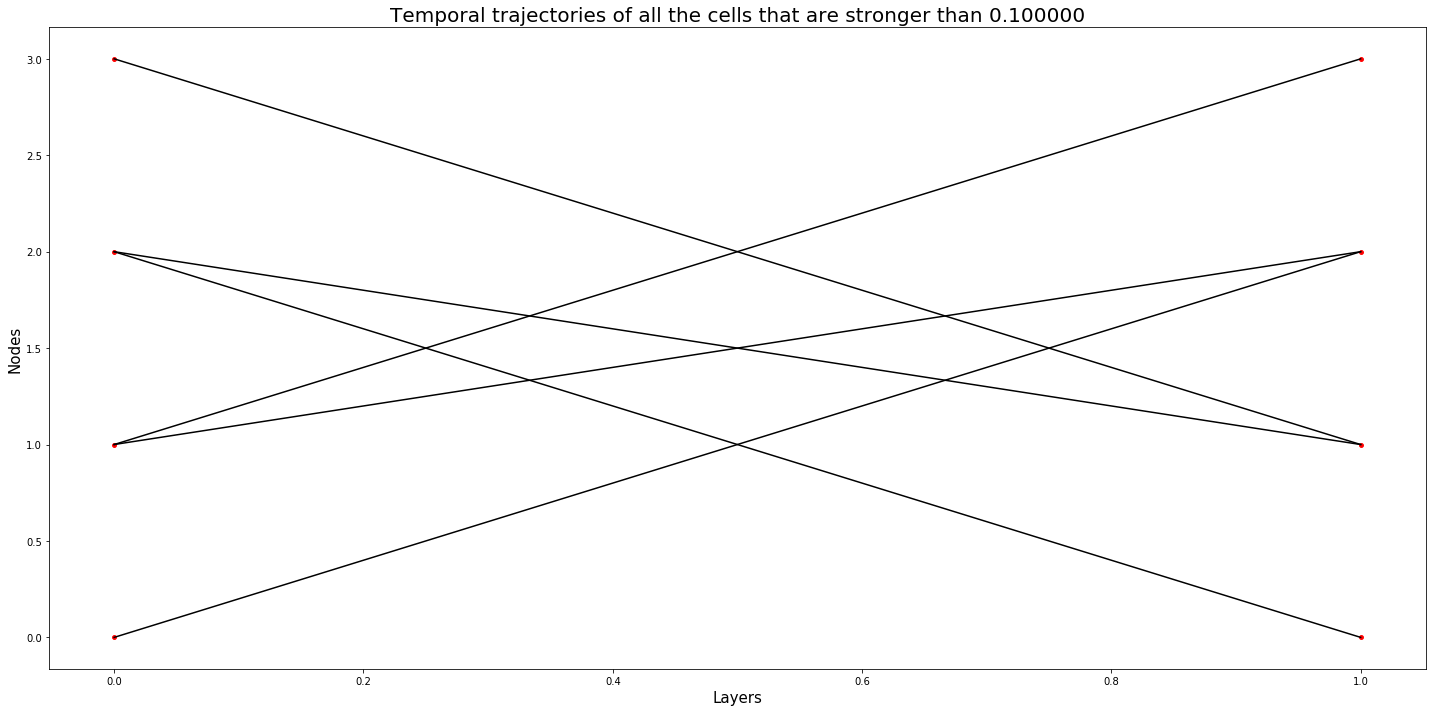

In [12]:
TN_test.trajectories(thresh = 0.1, node_id = None, community = None, edge_color = False, pv = None)